In [3]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder

from melusine import load_email_data

# Text input 
df_emails_preprocessed = load_email_data(type="full")
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [4]:
# Requirement : have a pretrained Embedding
from melusine.nlp_tools.embedding import Embedding
pretrained_embedding = Embedding(tokens_column="tokens", workers=1, min_count=5)
pretrained_embedding.train(df_emails_preprocessed)

In [5]:
# Metadata input
df_meta = pd.read_csv('/home/jupyter/melusine/melusine/data/metadata.csv', encoding='utf-8', sep=';')

# Dataset
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
import ast
import pandas as pd
import numpy as np
df_emails_preprocessed = pd.read_pickle('/home/jupyter/melusine/melusine/data/emails_preprocessed.pkl')

df_emails_preprocessed['clean_header'] = df_emails_preprocessed['clean_header'].astype(str)
df_emails_preprocessed['clean_body'] = df_emails_preprocessed['clean_body'].astype(str)
df_emails_preprocessed['attachment'] = df_emails_preprocessed['attachment'].apply(ast.literal_eval)
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [7]:
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
from melusine.models.train import NeuralModel

In [10]:
len(np.unique(y))

11

# Deterministic model

In [11]:
from melusine.models.neural_architectures import cnn_model
deterministic_nn_model = NeuralModel(architecture_function=cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [12]:
deterministic_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_deterministic = deterministic_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 448ms/step - loss: 2.3878 - accuracy: 0.1000
Epoch 2/40
2/2 [==============================] - 0s 7ms/step - loss: 2.2107 - accuracy: 0.4000
Epoch 3/40
2/2 [==============================] - 0s 7ms/step - loss: 2.1974 - accuracy: 0.2250
Epoch 4/40
2/2 [==============================] - 0s 7ms/step - loss: 2.1564 - accuracy: 0.2250
Epoch 5/40
2/2 [==============================] - 0s 10ms/step - loss: 2.0712 - accuracy: 0.2750
Epoch 6/40
2/2 [==============================] - 0s 9ms/step - loss: 1.9997 - accuracy: 0.3500
Epoch 7/40
2/2 [==============================] - 0s 7ms/step - loss: 1.9355 - accuracy: 0.3500
Epoch 8/40
2/2 [==============================] - 0s 10ms/step - loss: 1.8898 - accuracy: 0.3250
Epoch 9/40
2/2 [==============================] - 0s 9ms/step - loss: 1.7204 - accuracy: 0.4250
Epoch 10/40
2/2 [==============================] - 0s 8ms/step - loss: 1.8048 - accuracy: 0.4250
Epoch 11/40
2/2 [==================

### The deterministic model is able to give us point estimation of probabilities. But we can do better...

In [13]:
deterministic_nn_model.predict_proba(X)[:2]

array([[0.13546187, 0.08608879, 0.07862601, 0.08605198, 0.15096498,
        0.07331783, 0.09060791, 0.0731394 , 0.07013293, 0.0731362 ,
        0.08247205],
       [0.06576163, 0.05541243, 0.09382806, 0.08826976, 0.06840876,
        0.05418941, 0.09639449, 0.08213931, 0.09436362, 0.08306732,
        0.21816526]], dtype=float32)

# The probabilitic model 
The probabilitic gives us not longer point estimation but distribution on predictions. It allows us to give prediction intervals.

In [14]:
from melusine.models.probabilistic_neural_architectures import probabilistic_cnn_with_meta_model
probabilistic_model = NeuralModel(architecture_function=probabilistic_cnn_with_meta_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [15]:
probabilistic_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_probabilistic = probabilistic_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 1s 426ms/step - loss: 2.3900 - accuracy: 0.1500
Epoch 2/40
2/2 [==============================] - 0s 7ms/step - loss: 2.2798 - accuracy: 0.1750
Epoch 3/40
2/2 [==============================] - 0s 7ms/step - loss: 2.1116 - accuracy: 0.3000
Epoch 4/40
2/2 [==============================] - 0s 7ms/step - loss: 2.0224 - accuracy: 0.2750
Epoch 5/40
2/2 [==============================] - 0s 7ms/step - loss: 1.9910 - accuracy: 0.3000
Epoch 6/40
2/2 [==============================] - 0s 8ms/step - loss: 1.9681 - accuracy: 0.2500
Epoch 7/40
2/2 [==============================] - 0s 7ms/step - loss: 1.9436 - accuracy: 0.3750
Epoch 8/40
2/2 [==============================] - 0s 8ms/step - loss: 1.8815 - accuracy: 0.3500
Epoch 9/40
2/2 [==============================] - 0s 7ms/step - loss: 1.7977 - accuracy: 0.4250
Epoch 10/40
2/2 [==============================] - 0s 7ms/step - loss: 1.9024 - accuracy: 0.3500
Epoch 11/40
2/2 [====================

### The estimation of the probability is now the mean of the distribution of the prediction

In [16]:
X_input = probabilistic_model.prepare_email_to_predict(X)
probabilistic_model.model(X_input) # the output of the model is not a vector but a distribution we can sample/compute mean/compute std/...

<tfp.distributions.OneHotCategorical 'model_1_one_hot_categorical_OneHotCategorical_OneHotCategorical' batch_shape=[40] event_shape=[11] dtype=float32>

In [17]:
probabilistic_model.predict_proba(X)[:2]

array([[0.09251989, 0.06034808, 0.10122008, 0.12556857, 0.12800366,
        0.06595054, 0.1071038 , 0.06766497, 0.06315801, 0.06156524,
        0.12689714],
       [0.06471244, 0.04261582, 0.08491294, 0.11436494, 0.07694393,
        0.06066042, 0.07491909, 0.09476373, 0.10651657, 0.07405771,
        0.20553243]], dtype=float32)

### More important we now can have prediction intervals

In [18]:
score, inf, sup = probabilistic_model.predict_proba(X, prediction_interval=0.95)

In [19]:
import matplotlib.pyplot as plt
ntargets = 11


def analyse_and_plot_model_predictions(data, true_labels, nn_model, text_num, pi=0.95):
    """
    Make plots of the probabilities that the model estimates for a given text
    """
    true_label = true_labels[text_num]
    true_label_decoded = le.inverse_transform([true_label])[0]
    print('True label: \033[1m \033[92m {} \033[0m'.format(str(true_label_decoded)))
    print('Clean text: ', data.loc[text_num, "clean_text"])
    model_prediction, pct_low, pct_up = nn_model.predict_proba(data.loc[text_num:text_num], prediction_interval=pi)
    model_prediction, pct_low, pct_up = model_prediction[0], pct_low[0], pct_up[0]
    x_pos = np.arange(ntargets)
    bar = plt.bar(x_pos, pct_up, color='red')
    all_categories_decoded = le.inverse_transform(np.arange(ntargets))
    plt.xticks(x_pos, all_categories_decoded, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()
    for label, tick in zip(labels, ticks):
        if tick == true_label:
            label.set_color('green')
    bar[true_label].set_color('green')
    plt.bar(np.arange(ntargets), pct_low-0.02, color='white', linewidth=1, edgecolor='white')
    plt.ylim([0, 1])
    plt.ylabel('Probability')
    plt.title('Model estimated probabilities') 
    plt.show()

True label:   vehicule 
Clean text:  immatriculation voiture je vous informe que la nouvelle immatriculation est enfin faite. je vous prie de trouver donc la carte grise ainsi que la nouvelle immatriculation. je vous demanderai de faire les changements necessaires concernant lassurance.


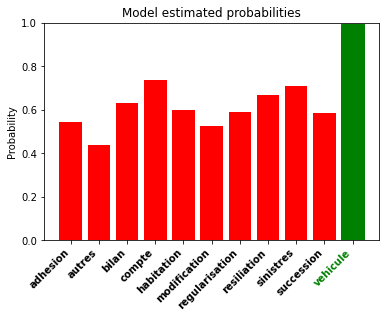

In [20]:
i = 1
analyse_and_plot_model_predictions(X, y, probabilistic_model, text_num=i, pi=0.95)

### Disclaimer
The dataset of this melusine tutorial is so small (40 emails) the model is always drawing large intervals. 
But if we apply this method on a large public datasets (like the movies dataset : 100 000 movies plots) we can see predictions with less uncertainty as on the following image.

<img src="images/uncertainty-on-movies-dataset.png" width=400 height=400 />

To let us see small interval (as a sanity check) we also can choose a very small prediction interval (0.01 instead of 0.95, but obviously 0.05 is not a serious value for prediction intervals) as on the following.

True label:   vehicule 
Clean text:  immatriculation voiture je vous informe que la nouvelle immatriculation est enfin faite. je vous prie de trouver donc la carte grise ainsi que la nouvelle immatriculation. je vous demanderai de faire les changements necessaires concernant lassurance.


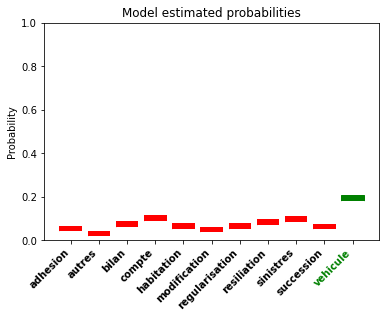

In [21]:
i = 1
analyse_and_plot_model_predictions(X, y, probabilistic_model, text_num=i, pi=0.01)

So instead of just having a point estimation score of being a `vehicle` verbatim (score=0.2) we can have uncertainty estimation around a point estimation (the score of being `vehicle` verbatim is in the interval [0.1 ; 0.3] with a 95% prediction interval).

# To go further : variational neural networks
We have 2 types of variational neural networks : [`Reparametrization` and `Flipout`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/conv_variational)

In [22]:
from melusine.models.probabilistic_neural_architectures import variational_cnn_model
reparametrization_nn_model = NeuralModel(architecture_function=variational_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=[],
                       n_epochs=40,
                       training_data_size=len(X))

In [23]:
reparametrization_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_reparametrization = reparametrization_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 597ms/step - loss: 7387.7891 - accuracy: 0.0250
Epoch 2/40
2/2 [==============================] - 0s 6ms/step - loss: 7381.6548 - accuracy: 0.0250
Epoch 3/40
2/2 [==============================] - 0s 5ms/step - loss: 7375.5264 - accuracy: 0.0250
Epoch 4/40
2/2 [==============================] - 0s 9ms/step - loss: 7369.3892 - accuracy: 0.0250
Epoch 5/40
2/2 [==============================] - 0s 6ms/step - loss: 7363.2578 - accuracy: 0.0250
Epoch 6/40
2/2 [==============================] - 0s 5ms/step - loss: 7357.1514 - accuracy: 0.1500
Epoch 7/40
2/2 [==============================] - 0s 5ms/step - loss: 7351.1045 - accuracy: 0.0250
Epoch 8/40
2/2 [==============================] - 0s 6ms/step - loss: 7345.0171 - accuracy: 0.0250
Epoch 9/40
2/2 [==============================] - 0s 5ms/step - loss: 7338.9868 - accuracy: 0.0250
Epoch 10/40
2/2 [==============================] - 0s 5ms/step - loss: 7332.8853 - accuracy: 0.2000
Epoch 1

True label:   vehicule 
Clean text:  pret vehicule ci-joint pret vehicule


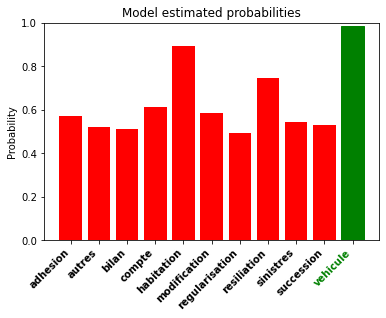

In [24]:
i = 9
analyse_and_plot_model_predictions(X, y, reparametrization_nn_model, i)

In [25]:
from melusine.models.probabilistic_neural_architectures import flipout_cnn_model
flipout_nn_model = NeuralModel(architecture_function=flipout_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=[],
                       n_epochs=40,
                       training_data_size=len(X))

In [26]:
flipout_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_flipout= flipout_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 404ms/step - loss: 3690.5554 - accuracy: 0.2500
Epoch 2/40
2/2 [==============================] - 0s 5ms/step - loss: 3687.4902 - accuracy: 0.2750
Epoch 3/40
2/2 [==============================] - 0s 6ms/step - loss: 3684.4304 - accuracy: 0.3000
Epoch 4/40
2/2 [==============================] - 0s 6ms/step - loss: 3681.3774 - accuracy: 0.2750
Epoch 5/40
2/2 [==============================] - 0s 6ms/step - loss: 3678.3301 - accuracy: 0.2750
Epoch 6/40
2/2 [==============================] - 0s 6ms/step - loss: 3675.2886 - accuracy: 0.3250
Epoch 7/40
2/2 [==============================] - 0s 5ms/step - loss: 3672.2539 - accuracy: 0.3000
Epoch 8/40
2/2 [==============================] - 0s 5ms/step - loss: 3669.2251 - accuracy: 0.3250
Epoch 9/40
2/2 [==============================] - 0s 7ms/step - loss: 3666.2017 - accuracy: 0.3250
Epoch 10/40
2/2 [==============================] - 0s 7ms/step - loss: 3663.1855 - accuracy: 0.3250
Epoch 1

True label:   vehicule 
Clean text:  pret vehicule ci-joint pret vehicule


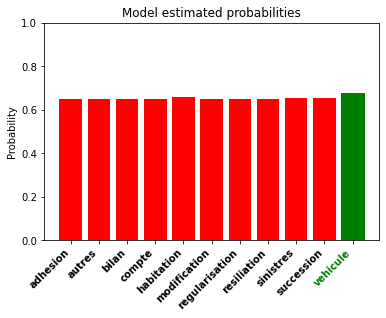

In [27]:
i = 9
analyse_and_plot_model_predictions(X, y, flipout_nn_model, i)

### Quick summary
We show 3 probabilistic models :
- **basic probabilistic** model with just a [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical) as last (prediction) layer
- **reparametrization** model with [Convolution1DReparameterization](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution1DReparameterization) layers
- **flipout** model with [Convolution1DFlipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution1DFlipout) layers

We simulation on a larger dataset (movies dataset), the basic probabilistic model is an effective lowcost solution to have uncertainty estimation of the prediction without any performance loss.

On our case, we did not manage to design a variational (reparametrization/flipout) neural architecture to get this level of performance.